In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

#Exploratory Data Analysis

Before beginning in-depth modeling, it's good to get a sense of what our data looks like. Perhaps we can see what variables seem to have relationships with one another which can forma a basis for predictive modeling.

In [2]:
#Load in the 3 US datasets
YearDat = pd.read_csv('YearDat.csv')
MonthDat = pd.read_csv('MonthDat.csv')
SeasonDat = pd.read_csv('SeasonDat.csv')

One of the best first steps is the get a sense the distribution of the various variables in the dataset. We can start by looking at the distribution of the several pollutants in our dataset to see how they vary by site. To begin with, just looking at yearly averages gives a general sense of how these pollutants fall across sites.

In [93]:
mapper = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
MonthDatMapped = MonthDat.copy()
MonthDatMapped['Month']=MonthDatMapped['month'].map(mapper.get)

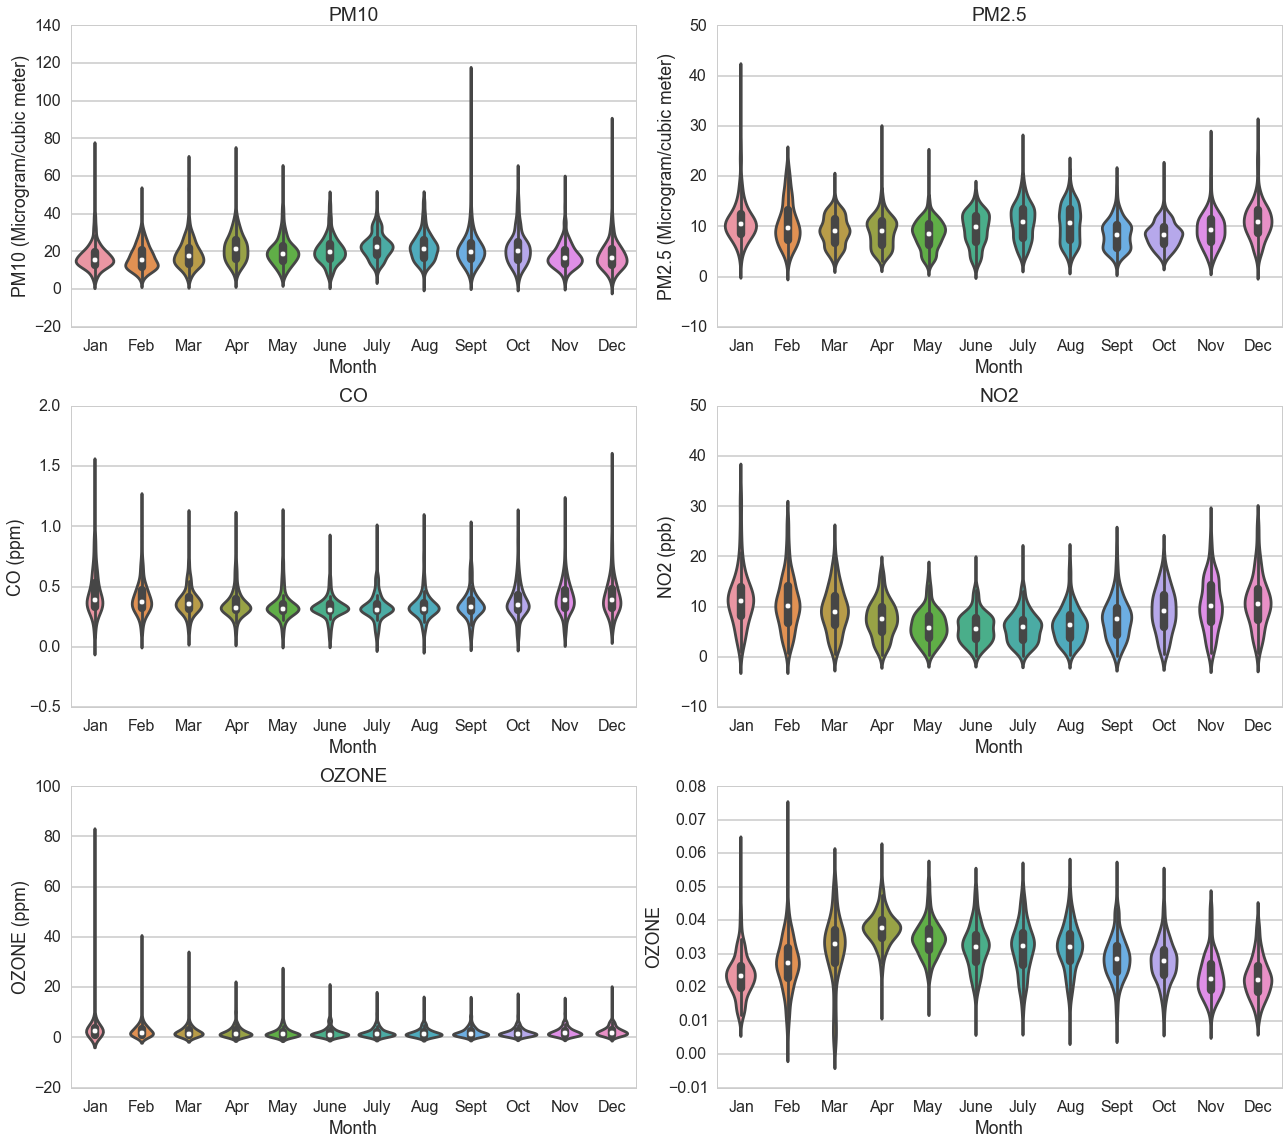

In [101]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
fig.set_tight_layout(True)
sns.violinplot(x='Month',y='PM10',data=MonthDatMapped, ax = axes[0,0])
axes[0,0].set_title('PM10')
axes[0,0].set_ylabel('PM10 (Microgram/cubic meter)')
sns.violinplot(x='Month',y='PM25_FRMFEM',data=MonthDatMapped, ax = axes[0,1])
axes[0,1].set_title('PM2.5')
axes[0,1].set_ylabel('PM2.5 (Microgram/cubic meter)')
sns.violinplot(x='Month',y='CO',data=MonthDatMapped, ax = axes[1,0])
axes[1,0].set_title('CO')
axes[1,0].set_ylabel('CO (ppm)')
sns.violinplot(x='Month',y='NO2',data=MonthDatMapped, ax = axes[1,1])
axes[1,1].set_title('NO2')
axes[1,1].set_ylabel('NO2 (ppb)')
sns.violinplot(x='Month',y='SO2',data=MonthDatMapped, ax = axes[2,0])
axes[2,0].set_title('SO2')
axes[2,0].set_ylabel('SO2 (ppb)')
sns.violinplot(x='Month',y='OZONE',data=MonthDatMapped, ax = axes[2,1])
axes[2,0].set_title('OZONE')
axes[2,0].set_ylabel('OZONE (ppm)')

In [65]:
MonthDat

,CBSA Name,month,Latitude,Longitude,PM25_FRMFEM,AQI_PM25_FRMFEM,PM25_NOFRMFEM,AQI_PM25_NOFRMFEM,PM10,AQI_PM10,TEMP,PRESS,RH,DP,WIND,CO,AQI_CO,NO2,AQI_NO2,OZONE,AQI_OZONE,SO2,AQI_SO2,id,MetArea,pop2010,landarea,popdense2010,pop_weight2010,alone,alone_frac,carpool,carpool_frac,other,other_frac,pt,pt_frac,total_trans
0,"Aberdeen, SD",1,45.462500,-98.486111,12.340000,46.800000,NaN,NaN,14.400000,13.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Aberdeen, SD",2,45.462500,-98.486111,16.033333,56.666667,NaN,NaN,21.000000,19.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Aberdeen, SD",3,45.462500,-98.486111,10.533333,40.444444,NaN,NaN,17.400000,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Aberdeen, SD",4,45.462500,-98.486111,7.520000,31.200000,NaN,NaN,24.800000,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Aberdeen, SD",5,45.462500,-98.486111,6.050000,25.400000,NaN,NaN,20.800000,19.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Aberdeen, SD",6,45.462500,-98.486111,6.840000,28.500000,NaN,NaN,21.200000,19.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Aberdeen, SD",7,45.462500,-98.486111,8.409091,34.909091,NaN,NaN,21.000000,19.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Aberdeen, SD",8,45.462500,-98.486111,9.200000,38.400000,NaN,NaN,25.200000,23.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Aberdeen, SD",9,45.462500,-98.486111,4.022222,16.777778,NaN,NaN,12.333333,11.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Aberdeen, SD",10,45.462500,-98.486111,7.550000,30.700000,NaN,NaN,30.166667,28.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([  35.,  141.,   56.,   12.,    6.,    1.,    1.,    0.,    0.,    1.]),
 array([  5.        ,  11.79166667,  18.58333333,  25.375     ,
         32.16666667,  38.95833333,  45.75      ,  52.54166667,
         59.33333333,  66.125     ,  72.91666667]),
 <a list of 10 Patch objects>)

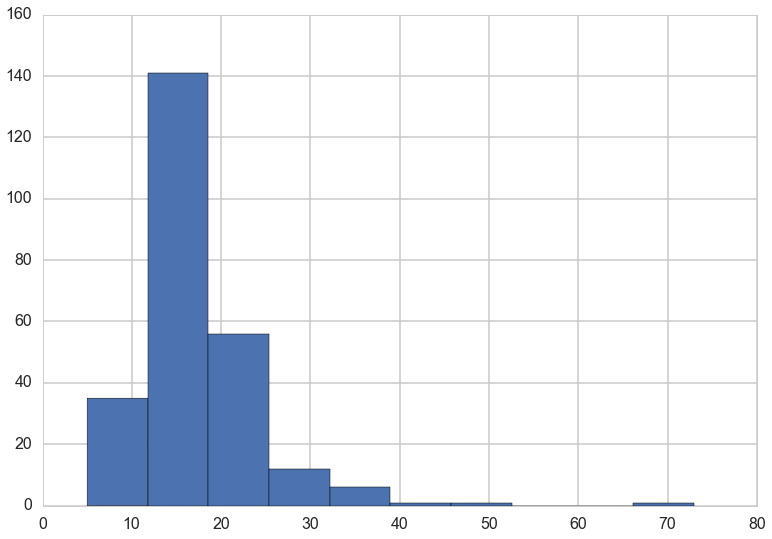

In [53]:
plt.hist(pm10['Jan'].dropna())


TypeError: can't multiply sequence by non-int of type 'float'

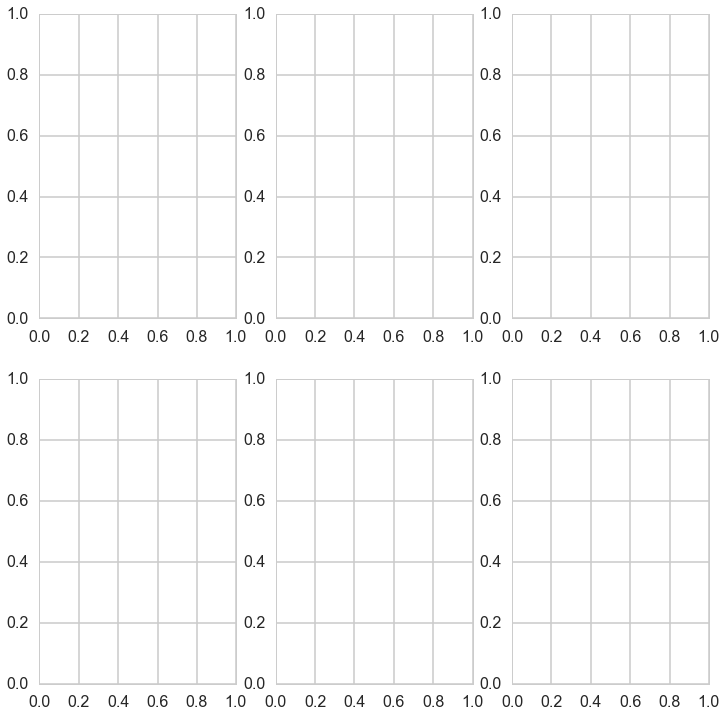

In [39]:
fs=18
pm10

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

axes[0, 0].violinplot(data, pos, points=20, widths=0.1,
                      showmeans=True, showextrema=True, showmedians=True)

In [27]:
MonthDat.shape

(6239, 38)

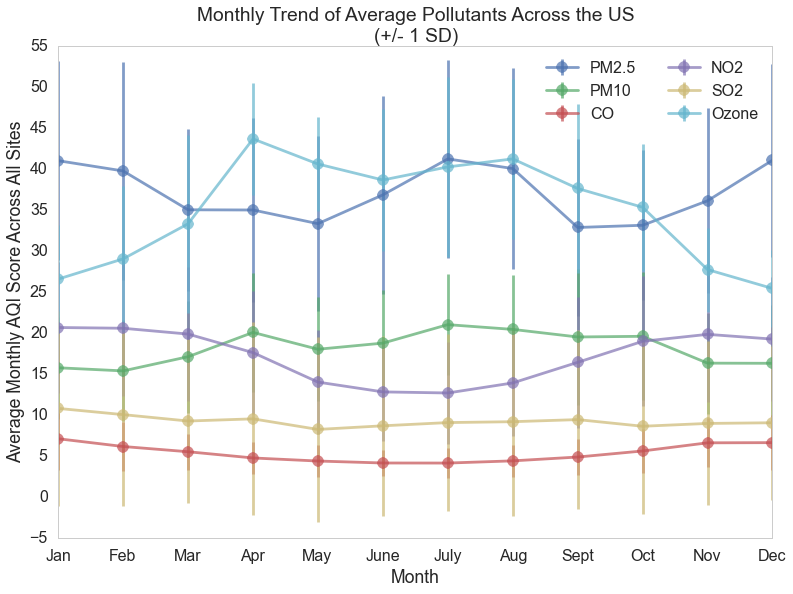

In [14]:
#Visualize the average pollutants monthly
#group all sites by month
group = MonthDat.groupby('month')
#Get the mean and sd over each month
plotVals = group.mean()
plotError = group.std()
#Initiate a plot and fill in the relevant info
fig, ax1 = plt.subplots()
plt.locator_params(nbins=12)
plt.grid(False)
plt.errorbar(plotVals.index,plotVals.AQI_PM25_FRMFEM, yerr=plotError.AQI_PM25_FRMFEM,label='PM2.5',alpha=.7,fmt='o-')
plt.errorbar(plotVals.index,plotVals.AQI_PM10, yerr=plotError.AQI_PM10,label='PM10',alpha=.7,fmt='o-')
plt.errorbar(plotVals.index,plotVals.AQI_CO, yerr=plotError.AQI_CO,label='CO',alpha=.7,fmt='o-')
plt.errorbar(plotVals.index,plotVals.AQI_NO2, yerr=plotError.AQI_NO2,label='NO2',alpha=.7,fmt='o-')
plt.errorbar(plotVals.index,plotVals.AQI_SO2, yerr=plotError.AQI_SO2,label='SO2',alpha=.7,fmt='o-')
plt.errorbar(plotVals.index,plotVals.AQI_OZONE, yerr=plotError.AQI_OZONE,label='Ozone',alpha=.7,fmt='o-')
ax1.set_xticklabels(('Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'))
ax1.set_xlabel('Month')
ax1.set_ylabel("Average Monthly AQI Score Across All Sites")
ax1.legend(loc='upper right',ncol=2)
plt.title('Monthly Trend of Average Pollutants Across the US\n(+/- 1 SD)')

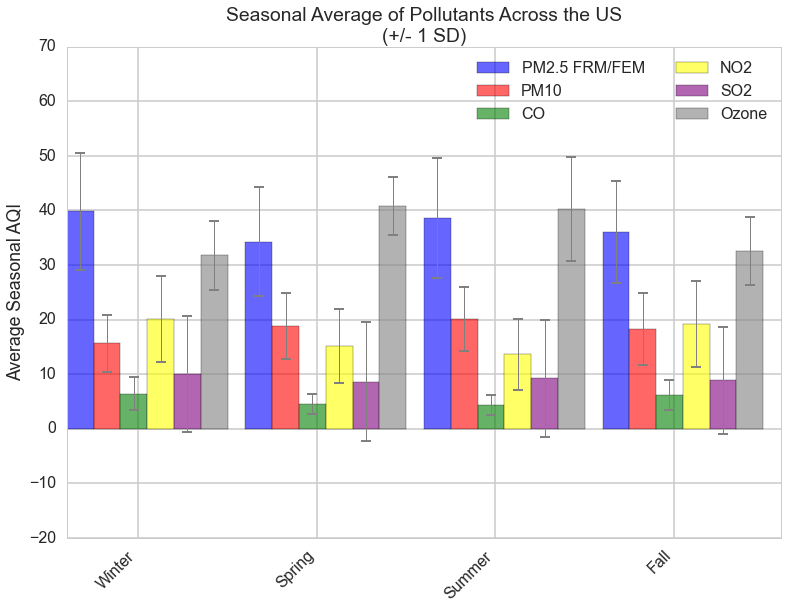

In [16]:
#Visualize the average pollutants by season
#Group by season
group = SeasonDat.groupby('season')
#Get group means and sd
plotVals = group.mean()
plotError = group.std()
#Intiate plots
fig, ax1 = plt.subplots()
#set the x-axis locations
x=[0,1,2,3]
#Plot bars and errors for each pollutant
pm25_bar=plt.bar(x,[float(plotVals[plotVals.index=='Winter']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Fall']['AQI_PM25_FRMFEM'])],
                  width=.15,color='blue',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_PM25_FRMFEM']),float(plotError[plotError.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotError[plotError.index=='Summer']['AQI_PM25_FRMFEM']),float(plotError[plotError.index=='Fall']['AQI_PM25_FRMFEM'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

pm10_bar=plt.bar([i+.15 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_PM10']),float(plotVals[plotVals.index=='Spring']['AQI_PM10']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM10']),float(plotVals[plotVals.index=='Fall']['AQI_PM10'])],
                  width=.15,color='red',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_PM10']),float(plotError[plotError.index=='Spring']['AQI_PM10']),
 float(plotError[plotError.index=='Summer']['AQI_PM10']),float(plotError[plotError.index=='Fall']['AQI_PM10'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

co_bar=plt.bar([i+.3 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_CO']),float(plotVals[plotVals.index=='Spring']['AQI_CO']),
 float(plotVals[plotVals.index=='Summer']['AQI_CO']),float(plotVals[plotVals.index=='Fall']['AQI_CO'])],
                  width=.15,color='green',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_CO']),float(plotError[plotError.index=='Spring']['AQI_CO']),
 float(plotError[plotError.index=='Summer']['AQI_CO']),float(plotError[plotError.index=='Fall']['AQI_CO'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

no2_bar=plt.bar([i+.45 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_NO2']),float(plotVals[plotVals.index=='Spring']['AQI_NO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_NO2']),float(plotVals[plotVals.index=='Fall']['AQI_NO2'])],
                  width=.15,color='yellow',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_NO2']),float(plotError[plotError.index=='Spring']['AQI_NO2']),
 float(plotError[plotError.index=='Summer']['AQI_NO2']),float(plotError[plotError.index=='Fall']['AQI_NO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

so2_bar=plt.bar([i+.6 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_SO2']),float(plotVals[plotVals.index=='Spring']['AQI_SO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_SO2']),float(plotVals[plotVals.index=='Fall']['AQI_SO2'])],
                  width=.15,color='purple',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_SO2']),float(plotError[plotError.index=='Spring']['AQI_SO2']),
 float(plotError[plotError.index=='Summer']['AQI_SO2']),float(plotError[plotError.index=='Fall']['AQI_SO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

ozone_bar=plt.bar([i+.75 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_OZONE']),float(plotVals[plotVals.index=='Spring']['AQI_OZONE']),
 float(plotVals[plotVals.index=='Summer']['AQI_OZONE']),float(plotVals[plotVals.index=='Fall']['AQI_OZONE'])],
                  width=.15,color='grey',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_OZONE']),float(plotError[plotError.index=='Spring']['AQI_OZONE']),
 float(plotError[plotError.index=='Summer']['AQI_OZONE']),float(plotError[plotError.index=='Fall']['AQI_OZONE'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

#Clean up the axes
plt.xticks([i+.4 for i in x],['Winter','Spring','Summer','Fall'],rotation=45,ha='right')
ax1.set_ylim(-20,70)
plt.ylabel('Average Seasonal AQI')
plt.legend((pm25_bar,pm10_bar,co_bar,no2_bar,so2_bar,ozone_bar),('PM2.5 FRM/FEM','PM10','CO','NO2','SO2','Ozone'),ncol=2)
plt.title('Seasonal Average of Pollutants Across the US\n(+/- 1 SD)')

C:\Users\Mark\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


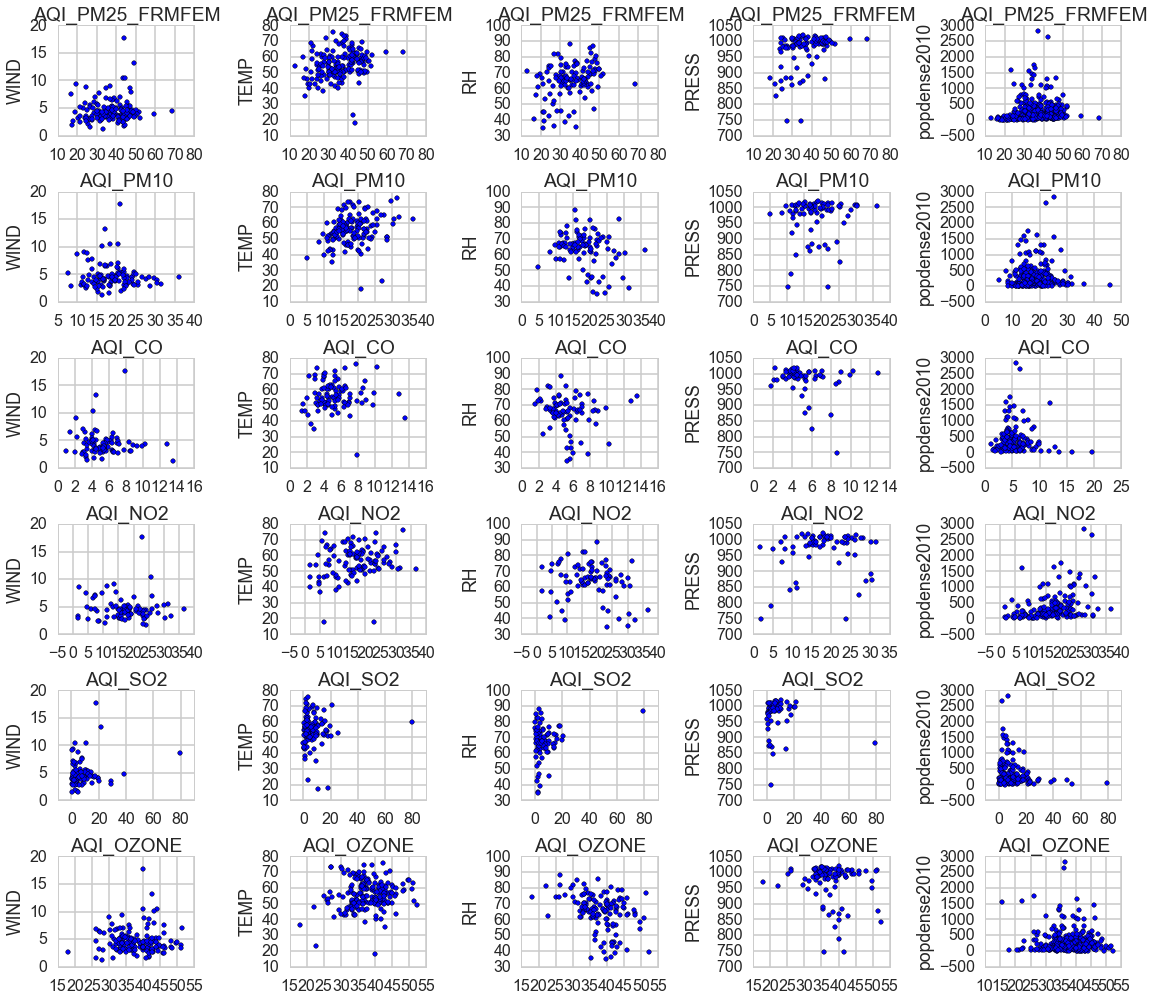

In [9]:
outcomes = ['AQI_PM25_FRMFEM',"AQI_PM10","AQI_CO","AQI_NO2",'AQI_SO2','AQI_OZONE']
predictors = ['WIND','TEMP','RH','PRESS','popdense2010']
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 14), 
                         tight_layout=True)
count = 0
for pol in outcomes:
    for pred in predictors:
        ax = axes.ravel()[count]
        plotting_dat = YearDat[[pol,pred]]
        ax.scatter(plotting_dat[pol],plotting_dat[pred])
        count += 1
        ax.set_title(pol)
        ax.set_ylabel(pred)
        #ax.annotate(pol, xy=(np.min(plotting_dat[pol]), np.max(plotting_dat[pred])), fontsize=14)